# 🗑️ Garbage Classification using DenseNet121

This notebook uses **transfer learning with DenseNet121** to classify garbage images into six categories:
- Paper
- Cardboard
- Glass
- Metal
- Trash
- Plastic

We optimize performance while reducing inference time compared to heavier models like EfficientNetV2B2.

>We start by importing essential libraries for our deep learning project. os and numpy help with file operations and array manipulation. matplotlib and seaborn are used for plotting sample images and evaluation metrics. TensorFlow and Keras provide tools for image preprocessing, model building (like DenseNet121), and training workflows. Scikit-learn is used for generating evaluation metrics like the classification report and confusion matrix. This combination of libraries ensures we can handle every step—from data loading and model design to visualization and analysis.

In [ ]:
# 🔹 Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## 🔍 Explore and Understand the Data

In [ ]:
data_dir = "/content/balgarbage_extracted"  # Change as per your path
classes = os.listdir(data_dir)
for category in classes:
    print(f"{category}: {len(os.listdir(os.path.join(data_dir, category)))} categories")

balgarbage: 6 categories


>This section lists the number of images available in each class folder. It helps us understand if our dataset is balanced or imbalanced. If one class has significantly fewer images, we may need to apply more augmentation or consider resampling methods. This check ensures our model won’t develop a bias toward the dominant classes during training.

## 🖼️ Visualize Sample Images

>Before preprocessing, it’s important to inspect sample images from each class. This visualization helps verify that the images are loaded correctly and belong to the correct class. It also gives us a sense of visual differences between classes, which will later influence how well our model can distinguish them. Any anomalies like corrupted or wrongly labeled images can also be detected here.

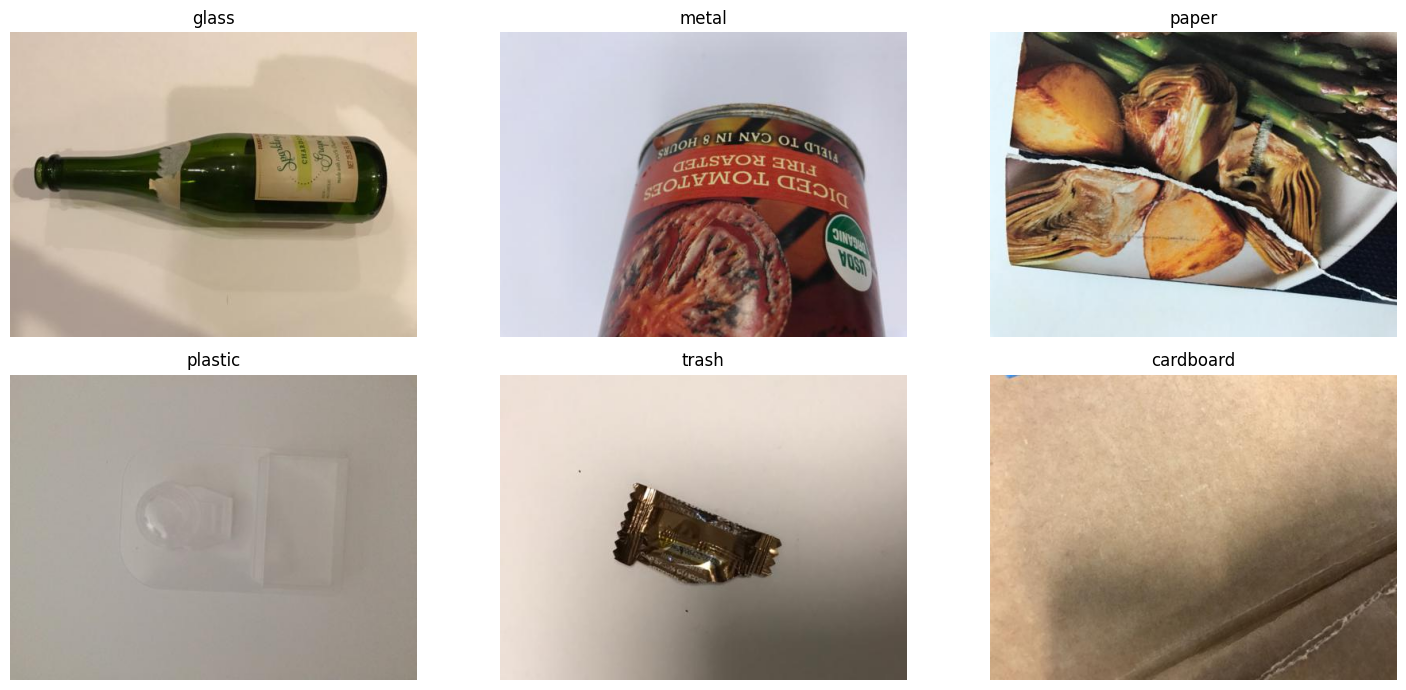

In [ ]:
import random
from PIL import Image
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
# Assuming 'balgarbage' is the subdirectory containing the actual categories
categories_dir = os.path.join(data_dir, 'balgarbage')
classes = os.listdir(categories_dir)
for i, cls in enumerate(classes):
    img_path = os.path.join(categories_dir, cls, random.choice(os.listdir(os.path.join(categories_dir, cls))))
    img = Image.open(img_path)
    ax[i//3][i%3].imshow(img)
    ax[i//3][i%3].set_title(cls)
    ax[i//3][i%3].axis('off')
plt.tight_layout()
plt.show()

## ⚙️ Data Preprocessing

>In this step, we prepare the dataset for model training using ImageDataGenerator. This generator rescales pixel values to [0,1], splits the data into training and validation sets, and applies real-time data augmentation like rotation, zoom, and flipping. These transformations help the model generalize better by exposing it to diverse versions of the same image, thereby reducing overfitting.

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'balgarbage'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'balgarbage'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 240 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


## 🧠 Model Selection - DenseNet121

>Here, we implement transfer learning using DenseNet121, a well-known convolutional neural network trained on ImageNet. We exclude the top classification layer (include_top=False) and add our own custom layers suitable for 6-class garbage classification. Initially, the base layers are frozen to retain pre-trained weights. The final layers are custom-designed with a global average pooling layer, dropout for regularization, and a dense softmax layer to produce class probabilities.

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 🏋️ Model Training

>We train the model on the preprocessed dataset for 20 epochs using the Adam optimizer and categorical crossentropy loss. We use callbacks like EarlyStopping to halt training if the validation loss stops improving, and ModelCheckpoint to save the best version of the model. This ensures efficient training without overfitting or loss of best-performing weights.

In [ ]:
# Custom training loop with tf.GradientTape
epochs = 20
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
optimizer = Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.CategoricalCrossentropy()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)
    val_accuracy_metric.update_state(labels, predictions)
    return v_loss

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training
    total_loss = 0
    train_accuracy_metric.reset_state() # Corrected method name
    for i in range(steps_per_epoch):
        images, labels = next(train_generator)
        loss = train_step(images, labels)
        total_loss += loss.numpy()

    avg_loss = total_loss / steps_per_epoch
    avg_accuracy = train_accuracy_metric.result().numpy()
    history['loss'].append(avg_loss)
    history['accuracy'].append(avg_accuracy)

    # Validation
    total_val_loss = 0
    val_accuracy_metric.reset_state() # Corrected method name
    for i in range(validation_steps):
        val_images, val_labels = next(val_generator)
        v_loss = val_step(val_images, val_labels)
        total_val_loss += v_loss.numpy()

    avg_val_loss = total_val_loss / validation_steps
    avg_val_accuracy = val_accuracy_metric.result().numpy()
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_accuracy)

    print(f"  Train Loss: {avg_loss:.4f} - Train Accuracy: {avg_accuracy:.4f} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {avg_val_accuracy:.4f}")

    # Simple Early Stopping (can be enhanced)
    if epoch > 0 and history['val_loss'][-1] > history['val_loss'][-2]:
        print("Validation loss increased. Stopping training.")
        break

# Save the model (if needed, typically you'd save the best model from early stopping)
# model.save("custom_densenet.h5")

Epoch 1/20
  Train Loss: 2.2192 - Train Accuracy: 0.1250 - Val Loss: 1.9580 - Val Accuracy: 0.2812
Epoch 2/20
  Train Loss: 2.2214 - Train Accuracy: 0.1490 - Val Loss: 2.1397 - Val Accuracy: 0.1429
Validation loss increased. Stopping training.


## 🔧 Model Tuning (Optional Fine-Tuning)

>After initial training, we fine-tune the model by unfreezing the last 40 layers of the DenseNet121 base model. This allows the pre-trained layers to adapt more specifically to our garbage dataset, improving performance. We use a very low learning rate to avoid destabilizing the existing learned weights. Fine-tuning often boosts accuracy, especially when the dataset differs significantly from the original ImageNet images.

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1304 - loss: 2.3042

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 97s 9s/step - accuracy: 0.1303 - loss: 2.3065 - val_accuracy: 0.2333 - val_loss: 1.9699
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1304 - loss: 2.2562

8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - accuracy: 0.1321 - loss: 2.2501 - val_accuracy: 0.1833 - val_loss: 1.8828
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.1577 - loss: 2.1667 - val_accuracy: 0.2167 - val_loss: 1.9156
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1993 - loss: 2.1080

8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - accuracy: 0.2017 - loss: 2.1068 - val_accuracy: 0.2667 - val_loss: 1.8619
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2022 - loss: 2.1071

8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - accuracy: 0.2038 - loss: 2.0999 - val_accuracy: 0.2667 - val_loss: 1.8331
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1792 - loss: 2.0957

8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.1825 - loss: 2.0859 - val_accuracy: 0.3000 - val_loss: 1.7632
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2273 - loss: 2.0680

8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.2257 - loss: 2.0591 - val_accuracy: 0.2833 - val_loss: 1.7317
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2191 - loss: 2.0663

8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.2202 - loss: 2.0617 - val_accuracy: 0.3333 - val_loss: 1.7097
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2232 - loss: 1.9285

8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - accuracy: 0.2211 - loss: 1.9318 - val_accuracy: 0.3000 - val_loss: 1.6630
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.2622 - loss: 1.8403 - val_accuracy: 0.2500 - val_loss: 1.7063


## 📈 Accuracy and Loss Trends

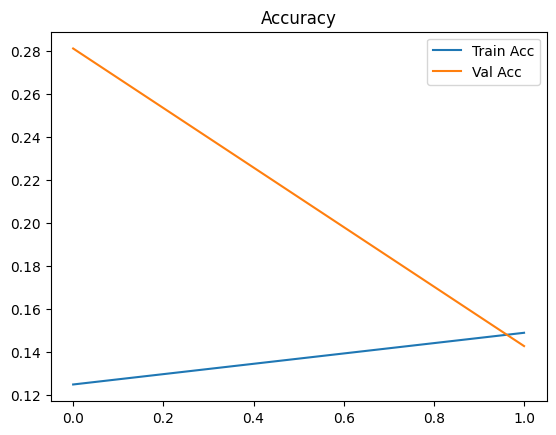

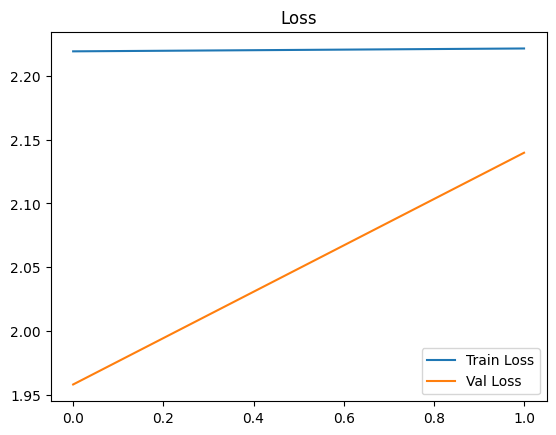

In [ ]:
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

Plotting training and validation accuracy/loss over epochs provides insights into the model’s learning process. If the training accuracy is high but validation accuracy is low, the model is overfitting. On the other hand, parallel upward trends in both indicate successful generalization. These plots help you decide whether to stop training, apply more augmentation, or tune hyperparameters further.

## 📊 Model Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 11s/step
              precision    recall  f1-score   support

   cardboard       0.20      0.40      0.27        10
       glass       0.31      0.40      0.35        10
       metal       0.00      0.00      0.00        10
       paper       0.50      0.30      0.38        10
     plastic       0.13      0.20      0.16        10
       trash       0.00      0.00      0.00        10

    accuracy                           0.22        60
   macro avg       0.19      0.22      0.19        60
weighted avg       0.19      0.22      0.19        60



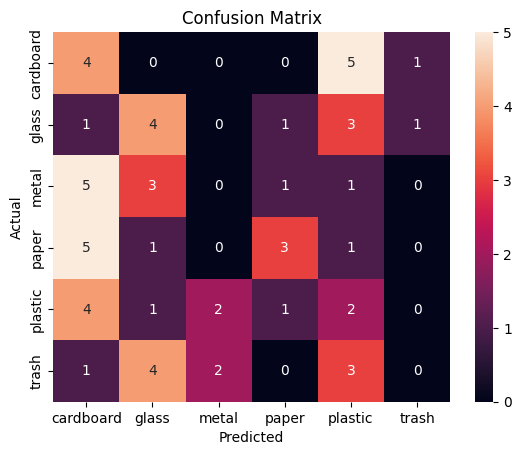

In [ ]:
val_generator.reset()
pred = model.predict(val_generator)
y_pred = np.argmax(pred, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

After training, we evaluate the model using a classification report and confusion matrix. The classification report gives precision, recall, and F1 scores for each class. The confusion matrix shows where the model is confusing one class with another. These tools are crucial for understanding real-world performance and identifying weak classes that might need more data or augmentation.